# Chemistry Lab 4 - Density
**Developed for the OOI Data Lab Notebook**

By Sage Lichtenwalner

Revised August 16, 2020.

This notebook is based on the [notebook](https://github.com/ooi-data-lab/data-lab-workshops/blob/master/August2019/DL_August_Density_v2.ipynb) developed for the [Drivers of Density](https://datalab.marine.rutgers.edu/explorations/2019/density.php) Data Exploration.

In [ ]:
# Notebook Setup
import requests
import os
import re
import xarray as xr
! pip install netcdf4
import matplotlib.pyplot as plt
import numpy as np

# Make the Plots pretty
import seaborn as sns
sns.set()

# Supress open_mfdataset warnings
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 1. Request Data from OOINet

* **Instruments:** 
  * CP04OSSM-RID27-03-CTDBPC000 - Coastal Pioneer Offshore Surface Mooring (7m)
  * GI03FLMA-RIM01-02-CTDMOG040 - Irminger Sea Flanking Mooring A (30m)
* **Time range:** 
  * 2018-07-01 00:00:00 to 2019-02-01 00:00:00

In [ ]:
def request_data(reference_designator,method,stream,start_date=None,end_date=None):
  site = reference_designator[:8]
  node = reference_designator[9:14]
  instrument = reference_designator[15:]
  
  # Create the request URL
  api_base_url = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv'
  data_request_url ='/'.join((api_base_url,site,node,instrument,method,stream))

  # All of the following are optional, but you should specify a date range
  params = {
    'format':'application/netcdf',
    'include_provenance':'true',
    'include_annotations':'true'
  }
  if (start_date):
    params['beginDT'] = start_date
  if (end_date):
    params['endDT'] = end_date

  # Make the data request
  r = requests.get(data_request_url, params=params, auth=(API_USERNAME, API_TOKEN))
  data = r.json()
  
  # Return just the THREDDS URL
  return data['allURLs'][0] 

In [ ]:
API_USERNAME = ''
API_TOKEN = ''

In [ ]:
# Data Requests
# request_data('GI03FLMA-RIM01-02-CTDMOG040','recovered_inst','ctdmo_ghqr_instrument_recovered',
#              '2018-01-01T00:00:00.000Z','2019-01-01T00:00:00.000Z')
# request_data('CP04OSSM-RID27-03-CTDBPC000','recovered_inst','ctdbp_cdef_instrument_recovered',
#              '2018-01-01T00:00:00.000Z','2019-01-01T00:00:00.000Z')


## 2. Load Data Files

In [ ]:
url_gi = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20200816T190701303Z-GI03FLMA-RIM01-02-CTDMOG040-recovered_inst-ctdmo_ghqr_instrument_recovered/catalog.html'
url_cp04 = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20200816T190809008Z-CP04OSSM-RID27-03-CTDBPC000-recovered_inst-ctdbp_cdef_instrument_recovered/catalog.html'

# Old Version
# url_gi = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20191218T185035986Z-GI03FLMA-RIM01-02-CTDMOG040-recovered_inst-ctdmo_ghqr_instrument_recovered/catalog.html'
# url_cp04 = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20191220T144211265Z-CP04OSSM-RID27-03-CTDBPC000-telemetered-ctdbp_cdef_dcl_instrument/catalog.html'

In [ ]:
def get_datalist(url):
  '''Return all the relevant .nc files from a specified OOI THREDDS url'''
  tds_url = 'https://opendap.oceanobservatories.org/thredds/dodsC'
  datasets = requests.get(url).text
  urls = re.findall(r'href=[\'"]?([^\'" >]+)', datasets)
  x = re.findall(r'(ooi/.*?.nc)', datasets)
  for i in x:
    if i.endswith('.nc') == False:
      x.remove(i)
  for i in x:
    try:
      float(i[-4])
    except:
      x.remove(i)
  datasets = [os.path.join(tds_url, i) for i in x]
  
  # Remove extraneous data files if necessary
  catalog_rms = url.split('/')[-2][20:]
  selected_datasets = []
  for d in datasets:
    if catalog_rms == d.split('/')[-1].split('_20')[0][15:]:
      selected_datasets.append(d + '#fillmismatch') # Add #fillmismatch to the URL to deal with a bug
  selected_datasets = sorted(selected_datasets)
  return selected_datasets

In [ ]:
# List of data files
gi_files = get_datalist(url_gi)
cp04_files = get_datalist(url_cp04)

In [ ]:
%%time
# Load Data
data_gi = xr.open_mfdataset(gi_files).swap_dims({'obs': 'time'})
data_cp04 = xr.open_mfdataset(cp04_files).swap_dims({'obs': 'time'})

CPU times: user 640 ms, sys: 170 ms, total: 810 ms
Wall time: 14.8 s


In [ ]:
import numpy as np
def reject_outliers(data, m=5):
    """
    Reject outliers beyond m standard deviations of the mean.
    :param data: numpy array containing data
    :param m: number of standard deviations from the mean. Default: 3
    """
    stdev = np.nanstd(data)
    if stdev > 0.0:
        ind = abs(data - np.nanmean(data)) < m * stdev
    else:
        ind = len(data) * [True]

    return ind

def clean_data(data,min=0,max=100):
  data = data.where((data>min) & (data<max))
  data = data.where(reject_outliers(data))
  return data


In [ ]:
# Remove Outliers
data_gi['practical_salinity'] = clean_data(data_gi['practical_salinity'])
data_gi['density'] = clean_data(data_gi['density'],1000,1100)
data_cp04['practical_salinity'] = clean_data(data_cp04['practical_salinity'])
data_cp04['density'] = clean_data(data_cp04['density'],1000,1100)

## Plot the Data

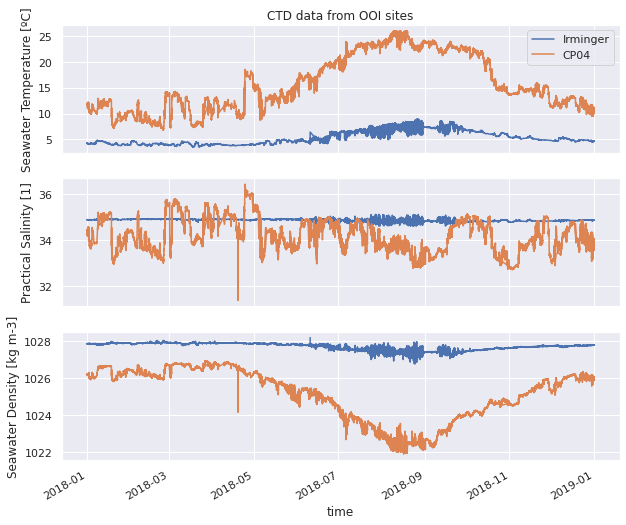

In [ ]:
fig,(ax1,ax2,ax3) = plt.subplots(3,1,sharex=True,figsize=(10,8))
data_gi.ctdmo_seawater_temperature.plot(ax=ax1,label='Irminger')
data_cp04.ctdbp_seawater_temperature.plot(ax=ax1,label='CP04')

# data_ce.practical_salinity.plot(ax=ax2)
data_gi.practical_salinity.plot(ax=ax2)
data_cp04.practical_salinity.plot(ax=ax2)

# data_ce.density.plot(ax=ax3)
data_gi.density.plot(ax=ax3)
data_cp04.density.plot(ax=ax3)

ax1.legend();

ax1.set_xlabel('');
ax2.set_xlabel('');
ax1.set_title('CTD data from OOI sites');

fig.savefig('ctd_data.png')

## Average and Merge

In [ ]:
%%time
# Subset and Average Datasets
avgint='1D'

a = data_gi[['practical_salinity','ctdmo_seawater_temperature','ctdmo_seawater_pressure','density']].load().sortby('time').resample(time=avgint).mean()
b = data_cp04[['practical_salinity','ctdbp_seawater_temperature','ctdbp_seawater_pressure','density']].load().sortby('time').resample(time=avgint).mean()


CPU times: user 1.29 s, sys: 76.5 ms, total: 1.36 s
Wall time: 4.08 s


In [ ]:
# Merge the datasets
a = a.rename({'practical_salinity':'GI Salinity',
              'ctdmo_seawater_temperature':'GI Temperature',
              'ctdmo_seawater_pressure':'GI Pressure',
              'density':'GI Density'})
b = b.rename({'practical_salinity':'CP04 Salinity',
              'ctdbp_seawater_temperature':'CP04 Temperature',
              'ctdbp_seawater_pressure':'CP04 Pressure',
              'density':'CP04 Density'})

data = xr.merge([a,b]).to_dataframe()

# Print the first few rows
data.head()

,GI Salinity,GI Temperature,GI Pressure,GI Density,CP04 Salinity,CP04 Temperature,CP04 Pressure,CP04 Density
time,,,,,,,,
2018-01-01,34.871888,4.200764,39.026143,1027.846269,34.375597,11.700381,7.173573,1026.196394
2018-01-02,34.865159,4.095880,38.548294,1027.849960,34.085584,10.867036,7.215305,1026.121953
2018-01-03,34.873071,4.172221,38.273122,1027.846777,33.732399,10.172733,7.310686,1025.969047
2018-01-04,34.873194,4.194348,37.390143,1027.840386,34.048703,10.803006,6.722383,1026.101188
2018-01-05,34.870683,4.130505,37.550273,1027.845990,34.202287,11.278322,6.808437,1026.137888


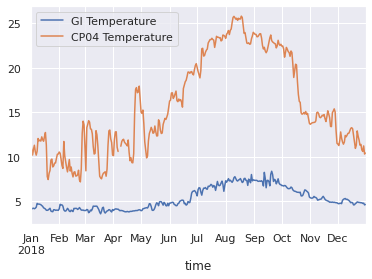

In [ ]:
# Test plot
data[['GI Temperature','CP04 Temperature']].plot();

## Recalculate Density 2 Ways

Next, for this activitiy, we actually want 3 different calculations of Seawater Density.
* Temp, Salinity, Density (from instrument)
* Density holding T constant (using mean T from the record)
* Density holding S constant (using mean S from the record)

To do this we will use the [python seawater library](https://pythonhosted.org/seawater/index.html). This library may be technically out of date, as the new [GSW-Python](https://github.com/TEOS-10/GSW-Python) library follows the TEOS-10 standard, but the differences are probably very minor for the purposes of this activity.

In [ ]:
! pip install seawater
import seawater as sw

In [ ]:
for site in ['GI','CP04']:
  print('Mean Salinity at %s: %f'%(site,data[site+' Salinity'].mean()))
  print('Mean Temperature at %s: %f'%(site,data[site+' Temperature'].mean()))
  print('Mean Pressure at %s: %f'%(site,data[site+' Pressure'].mean()))

Mean Salinity at GI: 34.857162
Mean Temperature at GI: 5.266311
Mean Pressure at GI: 36.918652
Mean Salinity at CP04: 34.187302
Mean Temperature at CP04: 15.751726
Mean Pressure at CP04: 7.208795


In [ ]:
# Add in recalculated Density
data['GI DenCS'] = sw.dens(data['GI Salinity'].mean(),data['GI Temperature'],data['GI Pressure'])
data['GI DenCT'] = sw.dens(data['GI Salinity'],data['GI Temperature'].mean(),data['GI Pressure'])

data['CP04 DenCS'] = sw.dens(data['CP04 Salinity'].mean(),data['CP04 Temperature'],data['CP04 Pressure'])
data['CP04 DenCT'] = sw.dens(data['CP04 Salinity'],data['CP04 Temperature'].mean(),data['CP04 Pressure'])


In [ ]:
# Add in Mean value columnns
data['GI MeanS'] = data['GI Salinity'].mean()
data['GI MeanT'] = data['GI Temperature'].mean()

data['CP04 MeanS'] = data['CP04 Salinity'].mean()
data['CP04 MeanT'] = data['CP04 Temperature'].mean()
data.head()

,GI Salinity,GI Temperature,GI Pressure,GI Density,CP04 Salinity,CP04 Temperature,CP04 Pressure,CP04 Density,GI DenCS,GI DenCT,CP04 DenCS,CP04 DenCT,GI MeanS,GI MeanT,CP04 MeanS,CP04 MeanT
time,,,,,,,,,,,,,,,,
2018-01-01,34.871888,4.200764,39.026143,1027.846269,34.375597,11.700381,7.173573,1026.196394,1027.832835,1027.722792,1026.046536,1025.355348,34.857162,5.266311,34.187302,15.751726
2018-01-02,34.865159,4.095880,38.548294,1027.849960,34.085584,10.867036,7.215305,1026.121953,1027.841869,1027.715253,1026.199010,1025.132378,34.857162,5.266311,34.187302,15.751726
2018-01-03,34.873071,4.172221,38.273122,1027.846777,33.732399,10.172733,7.310686,1025.969047,1027.832410,1027.720248,1026.320974,1024.861081,34.857162,5.266311,34.187302,15.751726
2018-01-04,34.873194,4.194348,37.390143,1027.840386,34.048703,10.803006,6.722383,1026.101188,1027.825922,1027.716263,1026.208198,1025.101817,34.857162,5.266311,34.187302,15.751726
2018-01-05,34.870683,4.130505,37.550273,1027.845990,34.202287,11.278322,6.808437,1026.137888,1027.833527,1027.715015,1026.122885,1025.220370,34.857162,5.266311,34.187302,15.751726


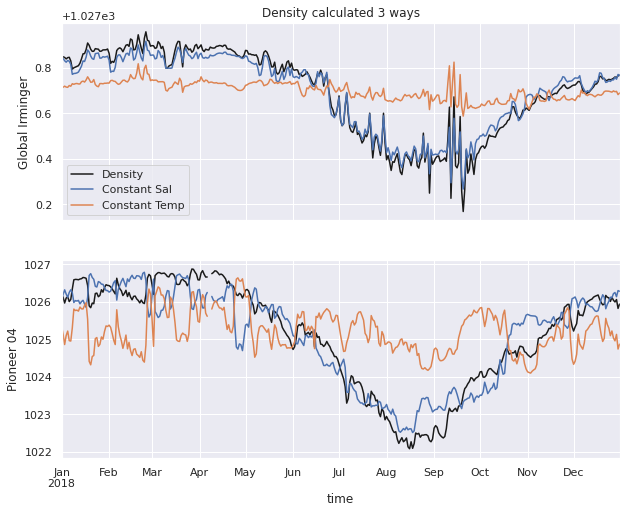

In [ ]:
# Let's plot all the Densities
fig,(ax1,ax2) = plt.subplots(2,1,sharex=True,figsize=(10,8))

data['GI Density'].plot(ax=ax1,label='Density',color='k')
data['GI DenCS'].plot(ax=ax1,label='Constant Sal')
data['GI DenCT'].plot(ax=ax1,label='Constant Temp')
ax1.set_ylabel('Global Irminger')

data['CP04 Density'].plot(ax=ax2,label='Density',color='k')
data['CP04 DenCS'].plot(ax=ax2,label='Constant Sal')
data['CP04 DenCT'].plot(ax=ax2,label='Constant Temp')
ax2.set_ylabel('Pioneer 04')

ax1.set_xlabel('');
ax1.legend();
ax1.set_title('Density calculated 3 ways');

fig.savefig('ctd_density.png')

In [ ]:
# Export to CSV
data.to_csv('density.csv')